## How to use 2D velocity estimate functions

This notebook shows how to use `two_dim_velocity_estimates.py` to get a 2D velocity field for experimental data (APD) using a time delay estimation method based on either
- cross correlation
- cross conditional average

APD stands for Avalanche Photodiodes which is a gas puff imaging diagnotic consisiting of 9x10 array of toroidal views of a localized gas puff.

Documentation on how to generate raw apd dataset: https://github.com/sajidah-ahmed/cmod_functions/blob/main/guides/how_to_use_raw_APD_datatset_function.ipynb

Documentation on xarray can be found here: https://docs.xarray.dev/en/stable/getting-started-guide/quick-overview.html

In [20]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import fppanalysis.two_dim_velocity_estimates as tdve
import fppanalysis.utils as u
import fppanalysis.time_delay_estimation as td
import cosmoplots

For experimental data:

(Note: Experimental data should be normalized. --> Normalize xarray dataset. Include LCFS and limiter position)

In [2]:
path = Path("~/notebooks/gpi") # Change this to your path
shot = 1111208034
#ds = xr.open_dataset(str(path) + "/" + f"apd_signal_array_{shot}.nc")   # Data is already extraced from the MDS tree

ds = xr.open_dataset("~/notebooks/gpi/1111208034_small.nc")

## Cross correlation

`estimate_velocity_field()` will return a class containing estimated velocity data of all pixels.

The estimation parameters are set in the EstimationOptions class, which is accepted as an argument of `estimate_velocity_field()`.

By default a cross-correlation based method is used to estimate time delays. This can be changed by setting EstimationOptions.method.

method = TDEMethod.CC is set as default

In [3]:
eo = tdve.EstimationOptions()
print(eo.method)

TDEMethod.CC


In addition to the own parameters in the EstimationOptions class, further time delay estimation options are specified in EstimationOptions.cc_options, EstimationOptions.cca_options and EstimationOptions.ccf_options. If you use cross-correlation time-delay estimation method (by setting method=TDEMethod.CC), you only need to specify EstimationOptions.cc_options, and likewise for the other methods.

In [8]:
print(eo.cc_options)

CC Window: 100, Running Mean: True, Running Mean Window Max: 7, Interpolate: False


Check out the documentation of the option class for the time delay estimation method you plan to use to get an overview of the parameters.
All parameters have default values, but most likely you will want to set some of these by your own.

Some important options are:

In [10]:
eo.use_3point_method # [bool] If False, use 2 point method to estimate velocities from time delays.

True

In [11]:
eo.cc_options.cc_window # Size of the window of time lags considered for the cross-correlation function

100

In [12]:
eo.cc_options.interpolate # Should interpolate ccf to find the maximum (if set to False, the time delays are restricted to integer multiples of the sampling time)

False

In [13]:
movie_data = tdve.estimate_velocity_field(ds, eo)

/home/sosno/Git/fpp-analysis-tools/fppanalysis/time_delay_estimation.py:486: UserWarning: Maximum running window achieved between pixels (3, 0) and (1, 0)
  if ccf is None:
/home/sosno/Git/fpp-analysis-tools/fppanalysis/time_delay_estimation.py:486: UserWarning: Maximum running window achieved between pixels (8, 3) and (8, 1)
  if ccf is None:
/home/sosno/Git/fpp-analysis-tools/fppanalysis/time_delay_estimation.py:486: UserWarning: Maximum running window achieved between pixels (8, 4) and (8, 3)
  if ccf is None:
/home/sosno/Git/fpp-analysis-tools/fppanalysis/time_delay_estimation.py:486: UserWarning: Maximum running window achieved between pixels (7, 9) and (7, 8)
  if ccf is None:


Extract estimated velocities and their confidences for each pixel

Confindeces are given as the maximum value of the cross correlation function at which the time lag is computed

In [14]:
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()

In [18]:
R_coordinates, Z_coordinates = u.get_rz_full(ds)

Use quiver to plot the velocity field.

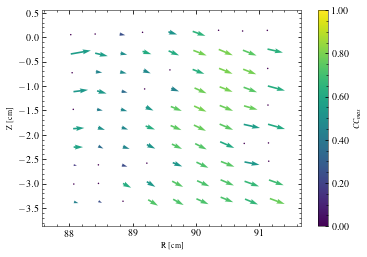

In [19]:
axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"

fig = plt.figure()
ax = fig.add_axes(axes_size)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    confidences,
    scale=210000,   # Scale arrows
    scale_units="xy",
    angles="xy",
    norm=norm,
)
cbar = fig.colorbar(qiv, format="%.2f")
cbar.ax.set_ylabel(r"$CC_{max} $")
ax.set_xlabel("R [cm]")
ax.set_ylabel("Z [cm]")
ax.set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0] + 0.5))
ax.set_xlim([min(R_coordinates[:, 0]) - 0.5, max(R_coordinates[:, 0]) + 0.5])
plt.show()

## Cross conditional average

To use cross conditional average, we need to change the default estimation options. To do that we instantiate an object of type EstimationOptions with method as TDEMethod.CA. The following parameters might then be relevant to set to non-default values aswell:

- min_threshold: Lowest threshold for conditional average method
- max_threshold: Maxiumum threshold for conditional average method
- delta: If window = True, delta is the minimal distance between two peaks.
- window: [bool] If True, delta also gives the minimal distance between peaks.


In [24]:
eo = tdve.EstimationOptions()
eo.method = td.TDEMethod.CA

min_threshold, max_threshold = 2.5, np.inf

eo.ca_options = td.CAOptions(min_threshold=min_threshold, max_threshold=max_threshold, delta=1.1e-4, window=True)

movie_data = tdve.estimate_velocity_field(ds, eo)

Extract estimated velocities and their confidences for each pixel

Confidences of the estimation is a value in the interval (0, 1) given by the
cross conditional variance for each event. OBS: We return 1-CV for cross conditional variance.

From conditional averaging we also obtain number of events for each average. This is another variable contained in the class.

In [25]:
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()
events = movie_data.get_events()

Use quiver to plot the velocity field. Here, number of events are plotted as the third dimension shown in the colorbar

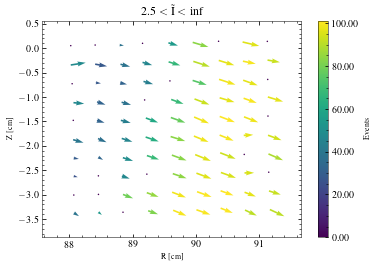

In [26]:
fig = plt.figure()
ax = fig.add_axes(axes_size)

norm = mpl.colors.Normalize(vmin=0, vmax=1500) if shot == 1111208034 else None
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    events,
    scale=210000, # Scale arrows
    scale_units="xy",
    angles="xy",
)
cbar = fig.colorbar(qiv, format="%.2f")
cbar.ax.set_ylabel("Events")
ax.set_xlabel("R [cm]")
ax.set_ylabel("Z [cm]")
ax.set_xlim([min(R_coordinates[:, 0]) - 0.5, max(R_coordinates[:, 0]) + 0.5])
ax.set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0] + 0.5))
ax.set_title(
    f"{min_threshold} "
    r"$ < \tilde{\mathrm{I}} < $ "
    f"{max_threshold}"
)
plt.show()